In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
%matplotlib inline 
import glob
from astropy.io.fits import getdata, getheader

In [2]:
# Setup NuSTAR time epochs:
launch_met=77241600. # 2012-06-13T00:00:00

from astropy.convolution import convolve, Box1DKernel


In [3]:
# Step one, sort all of the data:

for ind, file in enumerate(glob.glob('../full_mission/*A_02*')):
    # Load the header:
    hdr = getheader(file, 1)
#    dt_weeks = np.floor((hdr['TSTART'] - launch_met) / (7 * 86400.))
#    print(dt_weeks)
    stub= {'TSTART':np.float(hdr['TSTART']),
           'FNAME':file,
           'DATE-OBS':hdr['DATE-OBS']}
    if(ind==0):
        dbase = [stub]
    else:
        dbase.append(stub)


    



In [4]:
df = pd.DataFrame(dbase)
df_sorted = df.sort_values(by='TSTART')

interval = 7*86400. # Weekly
reset_interval=1

nlatbins = 48
nlonbins = 360

/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


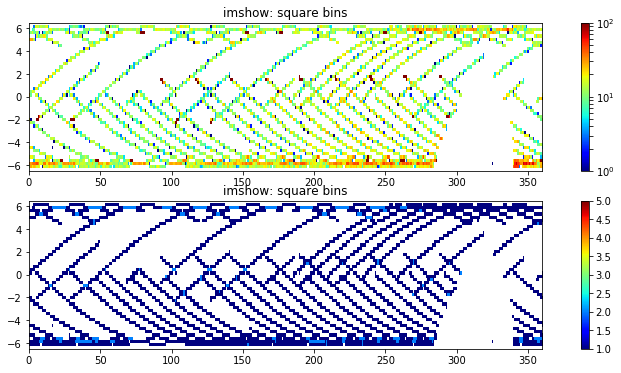

Press Enter to continue...


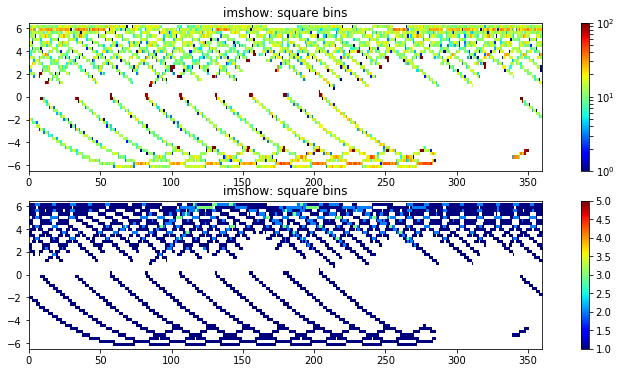

KeyboardInterrupt: 

In [8]:
for ind, file in enumerate(df_sorted['FNAME']):
    
    if (ind < 100):
        continue
    evt = getdata(file, 1)
    hdr = getheader(file, 1)
    if(reset_interval == 1):
        tmin = evt['TIME'].min()

    time_filter=( (evt['TIME'] - tmin) < interval).nonzero()

    thismap, xedges, yedges = np.histogram2d(evt['LON'][time_filter],
                             evt['LAT'][time_filter],
                             range = [[0, 360], [-6.5, 6.5]],
                             bins=[nlonbins, nlatbins])
#    plt.scatter(evt['LON'][time_filter], evt['LAT'][time_filter])

    if(reset_interval == 1):
        tmin = evt['TIME'].min()
        reset_interval=0
        allmap = thismap
        exposure = np.zeros_like(allmap)
    else:
        allmap+=thismap  
        filled = (thismap > 0).nonzero()
        exposure[filled] += 1.0

    if(max(evt['TIME']) > tmin + interval):    
        filled = (exposure > 0).nonzero()
        allmap[filled] = allmap[filled] / exposure[filled]

        plotmap = allmap.T
        plotexp = exposure.T

        empty =(plotmap == 0).nonzero()
        plotmap[empty]=np.nan
        plotexp[empty] = np.nan

        show_map(plotmap, plotexp)
        reset_interval=1
#        break


In [6]:
def show_map(map, exposure):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(211, title='imshow: square bins')
    plt.imshow(
                map,
                interpolation='nearest', origin='low',
                cmap=cm.jet, extent=[0, 360, -6.5, 6.5],
                aspect=8,
                norm=colors.LogNorm(vmin=1.0, vmax = 100.))
    plt.colorbar()

    ax = fig.add_subplot(212, title='imshow: square bins')
#     plt.show()

    plt.imshow(
                exposure,
                interpolation='nearest', origin='low',
                cmap=cm.jet, extent=[0, 360, -6.5, 6.5],
                aspect=8,vmin=1.0, vmax =5.)
    plt.colorbar()
    plt.show()
#     plt.close(fig)
    input("Press Enter to continue...")
    fig.clf()    

#plt.set_ytick(yedges)

#plt.gca().set_yticks(yedges)
# ax = fig.add_subplot(132, title='pcolormesh: actual edges',
#         aspect='equal')
# X, Y = np.meshgrid(xedges, yedges)
# ax.pcolormesh(X, Y, thismap)

#ax = fig.add_subplot(133, title='Scatter', aspect = 15)
#plt.scatter(evt['LON'][time_filter], evt['LAT'][time_filter])
#plt.xlim(0, 360)
#plt.ylim(-12, 12)


In [35]:
evt.columns

ColDefs(
    name = 'TIME'; format = 'D'
    name = 'DET_ID'; format = 'I'
    name = 'PI'; format = 'I'
    name = 'RAWX'; format = 'I'
    name = 'RAWY'; format = 'I'
    name = 'DEPTHFLAG'; format = 'I'
    name = 'GRADE'; format = 'I'
    name = 'GEOMAG'; format = 'E'
    name = 'SUNSHINE'; format = 'I'
    name = 'RAM_ANGLE'; format = 'E'
    name = 'LAT'; format = 'E'
    name = 'LON'; format = 'E'
    name = 'ALT'; format = 'E'
    name = 'LIMB_ANGLE'; format = 'E'
)

In [38]:
hdr

FITS_rec([ (86036140.394437939, 0, 670, 29, 29, 0, 0, 12.758349, 1, 75.410408, -5.7902346, 175.31714, 6997.1274, -14.955431),
       (86036142.257000864, 3, 98, 10, 12, 0, 2, 12.75831, 1, 75.33532, -5.7933164, 175.42511, 6997.1079, -14.918293),
       (86036143.849669054, 3, 3955, 6, 3, 0, 0, 12.758269, 1, 75.269119, -5.7959328, 175.51744, 6997.0913, -14.886163),
       ...,
       (86170625.110259324, 3, 211, 0, 15, 0, 0, 11.065071, 1, 54.189178, -5.1015825, 9.0003529, 6993.1528, 2.8865032),
       (86170625.309636503, 1, 3915, 12, 18, 0, 0, 11.065321, 1, 54.183456, -5.1008992, 9.0118952, 6993.1509, 2.8942816),
       (86170626.199468315, 2, 558, 21, 25, 0, 4, 11.066439, 1, 54.158062, -5.0978475, 9.0634089, 6993.1426, 2.9289317)], 
      dtype=(numpy.record, [('TIME', '>f8'), ('DET_ID', '>i2'), ('PI', '>i2'), ('RAWX', '>i2'), ('RAWY', '>i2'), ('DEPTHFLAG', '>i2'), ('GRADE', '>i2'), ('GEOMAG', '>f4'), ('SUNSHINE', '>i2'), ('RAM_ANGLE', '>f4'), ('LAT', '>f4'), ('LON', '>f4'), ('ALT', '>

In [40]:
hdr

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.12a          
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   46 /Number of bytes per row                         
NAXIS2  =                15520 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   14 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
TSTART  =        220798509.000 /                                                
MJDREF  =                   